In [57]:
# Import necessary libraries
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set display options
pd.set_option('display.width', 1000, 'display.max_colwidth', 100, 'display.max_columns', None)


Load in cleaned target, medclms, and rxclms datasets <br>(contains some feature engineering performed in Excel)

In [58]:
# Define a function to load data
def load_data(base_path):
    datasets = {}
    # List of filenames to load
    filenames = ['target_train_cleaned12.6', 'medclms_train_cleaned12.6', 'rxclms_train_cleaned12.6']

    for filename in filenames:
        dataset = pd.read_csv(f"{base_path}/{filename}.csv", low_memory=False, encoding='ISO-8859-1')
        #dataset.fillna('N/A', inplace=True)
        datasets[filename] = dataset

    return datasets


Define path

In [59]:
# Define the base path where the data is located
base_path = "/Users/nathanzlomke/Downloads"

# Load the datasets using the defined function
datasets = load_data(base_path)

In [60]:
datasets

{'target_train_cleaned12.6':               id             therapy_id therapy_start_date therapy_end_date  Date Duration tgt_ade_dc_ind   race_cd  est_age sex_cd cms_disabled_ind cms_low_income_ind
 0     1005597228  1005597228-TAGRISSO-1            3/11/20           9/7/20            180             No     White      NaN    NaN              NaN                NaN
 1     1005964858  1005964858-TAGRISSO-1            8/23/21          9/22/21             30            Yes     White     86.0      M               No                 No
 2     1007548572  1007548572-TAGRISSO-1            1/17/22          7/16/22            180             No     White     79.0      F               No                Yes
 3     1009508044  1009508044-TAGRISSO-1            1/23/20          7/21/20            180             No     White     70.0      F              Yes                Yes
 4     1028064791  1028064791-TAGRISSO-1            2/23/21          8/22/21            180             No     Black     74.0  

Merge datasets

In [61]:
datasets['rxclms_train_cleaned12.6'].rename(columns = {'ï»¿therapy_id':'therapy_id'}, inplace = 'True')

# Merge all datasets together on 'therapy_id' as the primary key using an inner join
merged_data = datasets['target_train_cleaned12.6'].merge(datasets['medclms_train_cleaned12.6'], on='therapy_id', how='left')  
merged_data = merged_data.merge(datasets['rxclms_train_cleaned12.6'], on='therapy_id', how='left')
merged_data.shape

(3896297, 87)

In [62]:
# Convert 'Yes' to 1 and 'No' to 0 in the 'tgt_ade_dc_ind' column
merged_data['tgt_ade_dc_ind'] = merged_data['tgt_ade_dc_ind'].replace({'Yes': 1, 'No': 0})

In [34]:
#optional export
#merged_data.to_csv("/Users/nathanzlomke/Downloads/CORRECTED_cleaned_humana_inner10-9.csv")

In [63]:
print("Print number of columns and rows in the DataFrame:")
print(f"Number of Columns before drop: {merged_data.shape[1]}")
print(f"Number of Rows before drop: {merged_data.shape[0]}\n")
initial_num_columns = merged_data.shape[1]
initial_num_rows = merged_data.shape[0]

Print number of columns and rows in the DataFrame:
Number of Columns before drop: 87
Number of Rows before drop: 3896297



In [48]:
merged_data.head()

,id,therapy_id,therapy_start_date,therapy_end_date,Date Duration,tgt_ade_dc_ind,race_cd,est_age,sex_cd,cms_disabled_ind,cms_low_income_ind,medclm_key,clm_unique_key,primary_diag_cd,visit_date,Visit_Duration,diag_cd2,diag_cd3,diag_cd4,diag_cd5,diag_cd6,diag_cd7,diag_cd8,diag_cd9,process_date_x,MedProcess_Duration,reversal_iNod_x,pot,util_cat,hedis_pot,clm_type_x,ade_diagnosis,seizure_diagnosis,pain_diagnosis,fatigue_diagnosis,nausea_diagnosis,hyperglycemia_diagnosis,constipation_diagnosis,diarrhea_diagnosis,PD_C00ÐD49_FLG,PD_D50ÐD89_FLG,PD_E00ÐE90_FLG,PD_G00ÐG99_FLG,PD_I00ÐI99_FLG,PD_J00ÐJ99_FLG,PD_M00ÐM99_FLG,PD_R00ÐR99_FLG,PD_Z00ÐZ99_FLG,PD_Other_FLG,NPD_C00ÐD49,NPD_D50ÐD89,NPD_E00ÐE90,NPD_G00ÐG99,NPD_I00ÐI99,NPD_J00ÐJ99,NPD_K00ÐK93,NPD_M00ÐM99,NPD_R00ÐR99,NPD_Z00ÐZ99,NPD_Other,NPD_SUM,document_key,ndc_id,service_date,process_date_y,Prescription_Filled_Duration,RX_Process_Duration,pay_day_supply_cnt,rx_cost,tot_drug_cost_accum_amt,reversal_iNod_y,mail_order_iNod,generic_ind,maint_ind,gpi_drug_group_desc,gpi_drug_class_desc,hum_drug_class_desc,strength_meas,metric_strength,specialty_ind,clm_type_y,ddi_ind,anticoag_ind,diarrhea_treat_ind,nausea_treat_ind,seizure_treat_ind,RxGroupings
0,1005597228,1005597228-TAGRISSO-1,3/11/20,9/7/20,180,0,White,N/A,N/A,N/A,N/A,1.113682e+10,9.170000e+17,G9389,1/16/20,-55.0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1/30/20,14.0,N/A,Unknown,N/A,Other,med,No,No,No,No,No,No,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B204176582141001,6.838203e+10,1/17/20,1/18/20,-54.0,1.0,4.0,1.60,0.0,No,No,GENERIC,NONMAINT,*ANALGESICS - OPIOID*,*OPIOID AGONISTS**,PAIN MGMT - NARCOTIC ANALGESICS,MG,50.0,NONSPCL,rx,No,No,No,No,No,Pain
1,1005597228,1005597228-TAGRISSO-1,3/11/20,9/7/20,180,0,White,N/A,N/A,N/A,N/A,1.113682e+10,9.170000e+17,G9389,1/16/20,-55.0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1/30/20,14.0,N/A,Unknown,N/A,Other,med,No,No,No,No,No,No,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B204176810231001,5.441842e+07,1/17/20,1/18/20,-54.0,1.0,7.0,19.00,0.0,No,No,GENERIC,NONMAINT,*CORTICOSTEROIDS*,*GLUCOCORTICOSTEROIDS**,STEROIDS,MG,4.0,NONSPCL,rx,No,No,No,No,No,CNS
2,1005597228,1005597228-TAGRISSO-1,3/11/20,9/7/20,180,0,White,N/A,N/A,N/A,N/A,1.113682e+10,9.170000e+17,G9389,1/16/20,-55.0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1/30/20,14.0,N/A,Unknown,N/A,Other,med,No,No,No,No,No,No,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B204812999131001,6.923811e+10,3/21/20,3/22/20,10.0,1.0,5.0,3.50,0.0,No,No,GENERIC,NONMAINT,*TETRACYCLINES*,*TETRACYCLINES**,ANTI-INFECTIVES,MG,100.0,NONSPCL,rx,No,No,No,No,No,Infection
3,1005597228,1005597228-TAGRISSO-1,3/11/20,9/7/20,180,0,White,N/A,N/A,N/A,N/A,1.113682e+10,9.170000e+17,G9389,1/16/20,-55.0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1/30/20,14.0,N/A,Unknown,N/A,Other,med,No,No,No,No,No,No,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B205236023921001,3.101350e+08,5/2/20,5/3/20,52.0,1.0,30.0,14992.27,0.0,No,No,BRANDED,NONMAINT,*ANTINEOPLASTICS AND ADJUNCTIVE THERAPIES*,*ANTINEOPLASTIC - EGFR INHIBITORS**,CHEMOTHERAPY,MG,80.0,SPCL,rx,No,No,No,No,No,Cancer
4,1005597228,1005597228-TAGRISSO-1,3/11/20,9/7/20,180,0,White,N/A,N/A,N/A,N/A,1.113682e+10,9.170000e+17,G9389,1/16/20,-55.0,N/A,N/A,N/A,N/A,N/A,N/A,N/A,N/A,1/30/20,14.0,N/A,Unknown,N/A,Other,med,No,No,No,No,No,No,No,No,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,B206138276621001,3.101350e+08,7/31/20,8/1/20,142.0,1.0,30.0,15292.12,0.0,No,No,BRANDED,NONMAINT,*ANTINEOPLASTICS AND ADJUNCTIVE THERAPIES*,*ANTINEOPLASTIC - EGFR INHIBITORS**,CHEMOTHERAPY,MG,80.0,SPCL,rx,No,No,No,No,No,Cancer


Feature Engineering

In [64]:
# Remove Columns Not required for our analysis

#merged_data = merged_data.drop(columns=['Unnamed: 0'], axis=1)


# Consolodating dataframe into necessary columns...
# 'Date Duration' was removed from this list, as it is not present in the HOLDOUT data
model_data = merged_data[
    ['therapy_id', 'Visit_Duration', 'MedProcess_Duration', 'pot', 'util_cat', 'hedis_pot', 'clm_type_x',
     'ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis', 'nausea_diagnosis',
     'hyperglycemia_diagnosis', 'constipation_diagnosis', 'diarrhea_diagnosis', 'PD_C00ÐD49_FLG',
     'PD_D50ÐD89_FLG', 'PD_E00ÐE90_FLG', 'PD_G00ÐG99_FLG', 'PD_I00ÐI99_FLG', 'PD_J00ÐJ99_FLG',
     'PD_M00ÐM99_FLG', 'PD_R00ÐR99_FLG', 'PD_Z00ÐZ99_FLG', 'PD_Other_FLG', 'NPD_C00ÐD49',
     'NPD_D50ÐD89', 'NPD_E00ÐE90', 'NPD_G00ÐG99', 'NPD_I00ÐI99', 'NPD_J00ÐJ99', 'NPD_K00ÐK93',
     'NPD_M00ÐM99', 'NPD_R00ÐR99', 'NPD_Z00ÐZ99', 'NPD_Other', 'NPD_SUM', 'Prescription_Filled_Duration',
     'RX_Process_Duration', 'pay_day_supply_cnt', 'rx_cost', 'tot_drug_cost_accum_amt', 'mail_order_iNod',
     'generic_ind', 'maint_ind', 'metric_strength', 'clm_type_y', 'clm_type_x', 'ddi_ind', 'anticoag_ind',
     'diarrhea_treat_ind', 'nausea_treat_ind', 'seizure_treat_ind', 'RxGroupings',
     'tgt_ade_dc_ind', 'race_cd', 'est_age', 'sex_cd', 'cms_disabled_ind', 'cms_low_income_ind']]

# Convert Categorical data back to binary for analysis
# Columns to replace 'Yes' with 1 and 'No' with 0
binary_columns = [
    'ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis',
    'nausea_diagnosis', 'constipation_diagnosis', 'diarrhea_diagnosis',
    'hyperglycemia_diagnosis', 'ddi_ind', 'anticoag_ind', 'diarrhea_treat_ind',
    'nausea_treat_ind', 'seizure_treat_ind', 'cms_disabled_ind', 'cms_low_income_ind'
]

Encoding binary categorical columns

In [65]:

# Need to convert all N/A values to 3s for third category.  
# Otherwise can't convert to numeric int.  ONLY FOR BINARY
# Apply replacements using a loop
for col in binary_columns:
    model_data.loc[:, col] = model_data[col].replace({'Yes': 1, 'No': 0})
    model_data.loc[:, col] = model_data[col].fillna(value=3)
    model_data.loc[:, col] = model_data[col].astype(int)

Ensuring numerical columns are numerical (integer)

In [66]:
model_data[['ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis',
    'nausea_diagnosis', 'constipation_diagnosis', 'diarrhea_diagnosis',
    'hyperglycemia_diagnosis', 'ddi_ind', 'anticoag_ind', 'diarrhea_treat_ind',
    'nausea_treat_ind', 'seizure_treat_ind', 'cms_disabled_ind', 'cms_low_income_ind']] = model_data[['ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis',
    'nausea_diagnosis', 'constipation_diagnosis', 'diarrhea_diagnosis',
    'hyperglycemia_diagnosis', 'ddi_ind', 'anticoag_ind', 'diarrhea_treat_ind',
    'nausea_treat_ind', 'seizure_treat_ind', 'cms_disabled_ind', 'cms_low_income_ind']].astype(int)

/var/folders/4s/dws9r14s699_2rwx3m1tvp5m0000gn/T/ipykernel_44107/131293048.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data[['ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis',


Imputing Missing Values (missing demographics given 3rd category for "unknown")

In [69]:
# Replace 'MAINT' with 1 and 'NONMAINT' with 0 in 'maint_ind' column
model_data['maint_ind'] = model_data['maint_ind'].replace({'MAINT': 1, 'NONMAINT': 0})

#Replace 'GENERIC' with 1 and 'BRANDED' with 0
model_data['generic_ind'] = model_data['generic_ind'].replace({'GENERIC': 1, 'BRANDED': 0})
model_data = model_data.drop('generic_ind', axis=1)

# Use pd.get_dummies for 'clm_type_y' and 'mail_order_iNod' columns
model_data = pd.get_dummies(model_data, columns=['clm_type_y', 'mail_order_iNod'], dtype=int, drop_first=False)

# Replace 'M' with 1 and 'F' with 0 in 'sex_cd' column
model_data['sex_cd'] = model_data['sex_cd'].replace({'M': 1, 'F': 0})

/var/folders/4s/dws9r14s699_2rwx3m1tvp5m0000gn/T/ipykernel_44107/477405525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['maint_ind'] = model_data['maint_ind'].replace({'MAINT': 1, 'NONMAINT': 0})
/var/folders/4s/dws9r14s699_2rwx3m1tvp5m0000gn/T/ipykernel_44107/477405525.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['generic_ind'] = model_data['generic_ind'].replace({'GENERIC': 1, 'BRANDED': 0})


In [ ]:

#Third category for NA
model_data['sex_cd'] = model_data['sex_cd'].fillna(value=3)
model_data['sex_cd'] = model_data['sex_cd'].astype(int)

#Fix NA columns: 'est_age' = avg(age)
model_data['est_age'] = model_data['est_age'].fillna(value=(model_data['est_age'].mean()))
model_data['est_age'] = model_data['est_age'].astype(int)

#Fix NA columns: 'metric_strength' = 0; this is usually in cases where it was supplies (e.g., syringes)
model_data['metric_strength'] = model_data['metric_strength'].fillna(value=0)
model_data['metric_strength'] = model_data['metric_strength'].astype(int)

Encoding more complex categories and joining them in

In [71]:
# Create dummy variables for 'RxGroupings', 'race_cd' and 'util_cat' columns
RX_GroupDF = pd.get_dummies(model_data['RxGroupings'], prefix='RXGrouping', dtype=int, drop_first=False)
Race_DF = pd.get_dummies(model_data['race_cd'], prefix='race', dtype=int, drop_first=False)
model_data = model_data.drop(columns=['race_cd'], axis=1)
model_data = model_data.drop(columns=['RxGroupings'], axis=1)

util_DF = pd.get_dummies(model_data['util_cat'], prefix='util_cat_', dtype=int, drop_first=False)
model_data = model_data.drop(columns=['util_cat'], axis=1)

# Display the first few rows of the 'Race_DF' DataFrame
Race_DF.head()

# Create a new DataFrame 'Dummies_df' and add 'Race_DF' and 'RX_GroupDF' as columns
Dummies_df = Race_DF
Dummies_df = Dummies_df.join(RX_GroupDF)
Dummies_df = Dummies_df.join(util_DF)
# Add 'Dummies_df' columns to the 'model_data' DataFrame
model_data = model_data.join(Dummies_df)

Trimming off string portion of therapy_id and converting to integer

In [72]:
#Keep only the numeric left portion of therapy_id so can be numeric
import re
test_id = model_data['therapy_id']
test_id
cleaned_id = []

i=0
for item in test_id:
    cleaned_item = re.sub(r'([-])\w+', '', item)
    cleaned_id.append(cleaned_item)
cleanedID_df = pd.DataFrame(cleaned_id)

cleanedID_df[0].astype(int)
cleanedID_df= cleanedID_df.rename(columns={0:"cleaned_id"})
cleanedID_df['cleaned_id'] = cleanedID_df['cleaned_id'].astype(int)
model_data = model_data.join(cleanedID_df)
model_data = model_data.drop(columns=['therapy_id'], axis=1)

Drop unnecessary columns and fill N/A values in other columns with 3 (i.e., "unknown")

In [73]:
model_data = model_data.drop(columns=['clm_type_x'], axis=1)
model_data = model_data.drop(columns=['pot'], axis=1)
model_data = model_data.drop(columns=['hedis_pot'], axis=1)

#Third category for NA

#Indices 10-13
MoreBinaryCol = model_data.iloc[:,10:31].columns.tolist()
for col in MoreBinaryCol:
    model_data.loc[:, col] = model_data[col].fillna(value=3)

#maint_ind change NA to 3
model_data['maint_ind'] = model_data['maint_ind'].fillna(value=3)
model_data['maint_ind'] = model_data['maint_ind'].astype(int)

Impute mean on additional missing data in numerical features

In [74]:

#Fix NA columns to impute mean: Visit_Duration, MedProcess_Duration, NPD_SUM, 
# Prescription_Filled_Duration, RX_Process_Duration, pay_day_supply_cnt, rx_cost,
#tot_drug_cost_accum_amt, 
ImputeMeanCol = model_data.iloc[:,31:37].columns.tolist()
ImputeMeanCol.append('Visit_Duration')
ImputeMeanCol.append('MedProcess_Duration')

for col in ImputeMeanCol:
    model_data.loc[:, col] = model_data.loc[:, col].fillna(value=(model_data.loc[:, col].mean()))
    model_data.loc[:, col] = model_data.loc[:, col].astype(int)


# Display information about the 'model_data' DataFrame
model_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896297 entries, 0 to 3896296
Data columns (total 82 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   Visit_Duration                float64
 1   MedProcess_Duration           float64
 2   ade_diagnosis                 int64  
 3   seizure_diagnosis             int64  
 4   pain_diagnosis                int64  
 5   fatigue_diagnosis             int64  
 6   nausea_diagnosis              int64  
 7   hyperglycemia_diagnosis       int64  
 8   constipation_diagnosis        int64  
 9   diarrhea_diagnosis            int64  
 10  PD_C00ÐD49_FLG                float64
 11  PD_D50ÐD89_FLG                float64
 12  PD_E00ÐE90_FLG                float64
 13  PD_G00ÐG99_FLG                float64
 14  PD_I00ÐI99_FLG                float64
 15  PD_J00ÐJ99_FLG                float64
 16  PD_M00ÐM99_FLG                float64
 17  PD_R00ÐR99_FLG                float64
 18  PD_Z00ÐZ99_FLG        

Ensure all data is numerical prior to loading into model

In [75]:
pd.set_option('display.max_rows', 100)
print(model_data.isnull().any())

Visit_Duration                  False
MedProcess_Duration             False
ade_diagnosis                   False
seizure_diagnosis               False
pain_diagnosis                  False
fatigue_diagnosis               False
nausea_diagnosis                False
hyperglycemia_diagnosis         False
constipation_diagnosis          False
diarrhea_diagnosis              False
PD_C00ÐD49_FLG                  False
PD_D50ÐD89_FLG                  False
PD_E00ÐE90_FLG                  False
PD_G00ÐG99_FLG                  False
PD_I00ÐI99_FLG                  False
PD_J00ÐJ99_FLG                  False
PD_M00ÐM99_FLG                  False
PD_R00ÐR99_FLG                  False
PD_Z00ÐZ99_FLG                  False
PD_Other_FLG                    False
NPD_C00ÐD49                     False
NPD_D50ÐD89                     False
NPD_E00ÐE90                     False
NPD_G00ÐG99                     False
NPD_I00ÐI99                     False
NPD_J00ÐJ99                     False
NPD_K00ÐK93 

Optional Export

In [ ]:
#model_data.to_csv("/Users/nathanzlomke/Downloads/CORRECTED_model_data10-9.csv", index=0)

### Model Building

In [76]:
# Import necessary Libraries
from lightgbm import LGBMClassifier
import lightgbm as lgb

Assign training dataset

In [78]:
train = model_data

#IF WANT TO EXPLICITLY READ IN
#train = pd.read_csv("/Users/nathanzlomke/Downloads/CORRECTED_model_data10-9.csv")  

#took off encoding="ISO-8859-1" as it was causing glitching
#train = train.drop(columns={'Date Duration'}, axis=1)

#Drop erroneous columns
#train = train.drop(columns={'Date clm_type_y_0', 'mail_order_iNod_0', 'race_0', 'RXGrouping_0', 'util_cat__0'}, axis=1)
train.shape
train.columns

Index(['Visit_Duration', 'MedProcess_Duration', 'ade_diagnosis', 'seizure_diagnosis', 'pain_diagnosis', 'fatigue_diagnosis', 'nausea_diagnosis', 'hyperglycemia_diagnosis', 'constipation_diagnosis', 'diarrhea_diagnosis', 'PD_C00ÐD49_FLG', 'PD_D50ÐD89_FLG', 'PD_E00ÐE90_FLG', 'PD_G00ÐG99_FLG', 'PD_I00ÐI99_FLG', 'PD_J00ÐJ99_FLG', 'PD_M00ÐM99_FLG', 'PD_R00ÐR99_FLG', 'PD_Z00ÐZ99_FLG', 'PD_Other_FLG', 'NPD_C00ÐD49', 'NPD_D50ÐD89', 'NPD_E00ÐE90', 'NPD_G00ÐG99', 'NPD_I00ÐI99', 'NPD_J00ÐJ99', 'NPD_K00ÐK93', 'NPD_M00ÐM99', 'NPD_R00ÐR99', 'NPD_Z00ÐZ99', 'NPD_Other', 'NPD_SUM', 'Prescription_Filled_Duration', 'RX_Process_Duration', 'pay_day_supply_cnt', 'rx_cost', 'tot_drug_cost_accum_amt', 'maint_ind', 'metric_strength', 'ddi_ind', 'anticoag_ind', 'diarrhea_treat_ind', 'nausea_treat_ind', 'seizure_treat_ind', 'tgt_ade_dc_ind', 'est_age', 'sex_cd', 'cms_disabled_ind', 'cms_low_income_ind', 'clm_type_y_rx', 'mail_order_iNod_No', 'mail_order_iNod_Yes', 'race_Black', 'race_Hispanic',
       'race_Nort

Assign test dataset

In [79]:
test = pd.read_csv("/Users/nathanzlomke/Documents/GitHub/ban5753-fall2023-rxdata/Humana-Mays Competition/Humana_Confidential_Analytics/CORRECTED_CLEAN_HOLDOUT_12-6.csv")

#None of the below 3 categories are in holdout file, so need to add as columns = 0 for model to work
test['race_North American Native']= 0
test['util_cat__IP_LTACH'] = 0
test['util_cat__IP_MHSA'] = 0
test.shape
test_new = test

#placeholder values for tgt column to avoid error
test_new['tgt_ade_dc_ind']= 0

In [80]:
# Define X and y for training and testing
x_train = train.drop(columns=(['tgt_ade_dc_ind', 'cleaned_id']), axis=1)
y_train = train['tgt_ade_dc_ind']
x_test = test_new.drop(columns=(['tgt_ade_dc_ind', 'cleaned_id']), axis=1)
y_test = test_new['tgt_ade_dc_ind']

### USE IF RUNNING OPTIMIZATION:

In [102]:
#This section uses an algorithm RandomSearchCV to optimize the model parameters for the model to use in the next section
from sklearn.model_selection import RandomizedSearchCV
seed=0
lgbm_params = {
    "n_estimators":[500],#, 700, 900],
    "learning_rate":[0.05],#, 0.1, 0.3],
    #"num_leaves": [7 ,12, 15]
    "num_leaves": [15]
}
#USE IF OPTIMIZING PARAMETERS

rand = RandomizedSearchCV(LGBMClassifier(seed=seed), lgbm_params, n_iter=10, cv=3, scoring='roc_auc',  random_state=1)
rand.fit(x_train,y_train)
rand.best_score_

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 512786, number of negative: 2084745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.284152 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1777
[LightGBM] [Info] Number of data points in the train set: 2597531, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.197413 -> initscore=-1.402543
[LightGBM] [Info] Start training from score -1.402543
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 512786, number of negative: 2084745
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.424398 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set 

0.5894482123502581

In [103]:
rand.best_params_

{'num_leaves': 15, 'n_estimators': 500, 'learning_rate': 0.05}

{'num_leaves': 12, 'n_estimators': 500, 'learning_rate': 0.1}<br>
{'num_leaves': 12, 'n_estimators': 700, 'learning_rate': 0.1}<br>
***BEST is {'num_leaves': 15, 'n_estimators': 500, 'learning_rate': 0.05}

In [93]:
lgmc = LGBMClassifier(seed=seed)
from sklearn.model_selection import RandomizedSearchCV

rand = LGBMClassifier(seed=seed, n_estimators=500, learning_rate = 0.05, num_leaves = 15, n_iter=10, cv=3, scoring='roc_auc',  random_state=1)
rand.fit(x_train,y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/lightgbm/engine.py:172: UserWarning: Found `n_iter` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] Unknown parameter: cv
[LightGBM] [Warning] seed is set=0, random_state=1 will be ignored. Current value: seed=0
[LightGBM] [Warning] num_iterations is set=10, n_iter=10 will be ignored. Current value: num_iterations=10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: scoring
[LightGBM] [Warning] Unknown parameter: cv
[LightGBM] [Warning] seed is set=0, random_state=1 will be ignored. Current value: seed=0
[LightGBM] [Info] Number of positive: 769179, number of negative: 3127118
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.421844 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1865
[LightGBM] [Info] Number of data points in the train set: 3896297, number of used features: 80
[LightGBM] [Info] [bin

LGBMClassifier(cv=3, learning_rate=0.05, n_estimators=500, n_iter=10,
               num_leaves=15, random_state=1, scoring='roc_auc', seed=0)

In [104]:
# Predict the target variable
pred = rand.predict(x_test)
print(pred)

[1 1 0 ... 1 1 1]


In [107]:
#Can't do this with holdout as don't know real values
# Evaluate model performance (consider using additional metrics)
'''accuracy = rand.score(x_test, y_test)
print("Accuracy:", accuracy)
print(y_test)'''

'accuracy = rand.score(x_test, y_test)\nprint("Accuracy:", accuracy)\nprint(y_test)'

In [108]:
#Printing the scored results and joining to test dataframe
pred = pd.DataFrame(pred)
pred = pred.rename(columns={0:'tgt_ade_dc_ind'})
test_scored = x_test.join(pred)
test_scored = test_scored.join(test_new['cleaned_id'])

Average the values on 'cleaned_id' to get predicted probabilities

In [109]:
short_test_scored = test_scored[['cleaned_id','tgt_ade_dc_ind']]
short_test_scored.head()

grouped = short_test_scored.groupby('cleaned_id')
average_id = grouped.mean()
average_id.shape
average_id.head()

,tgt_ade_dc_ind
cleaned_id,
1000261259,0.739171
1001691228,1.000000
1002060555,0.761905
1003935675,0.000000
1004837018,0.000000


In [110]:
short_test_scored['cleaned_id'].nunique()
#x_test['cleaned_id'].nunique()

420

Export scoring file for evaluation

In [111]:
#Export to CSV
average_id.to_csv("/Users/nathanzlomke/Downloads/scoring_12_6.csv")

## Post Model Analysis

In [113]:
import graphviz

Show tree structure

<Axes: >

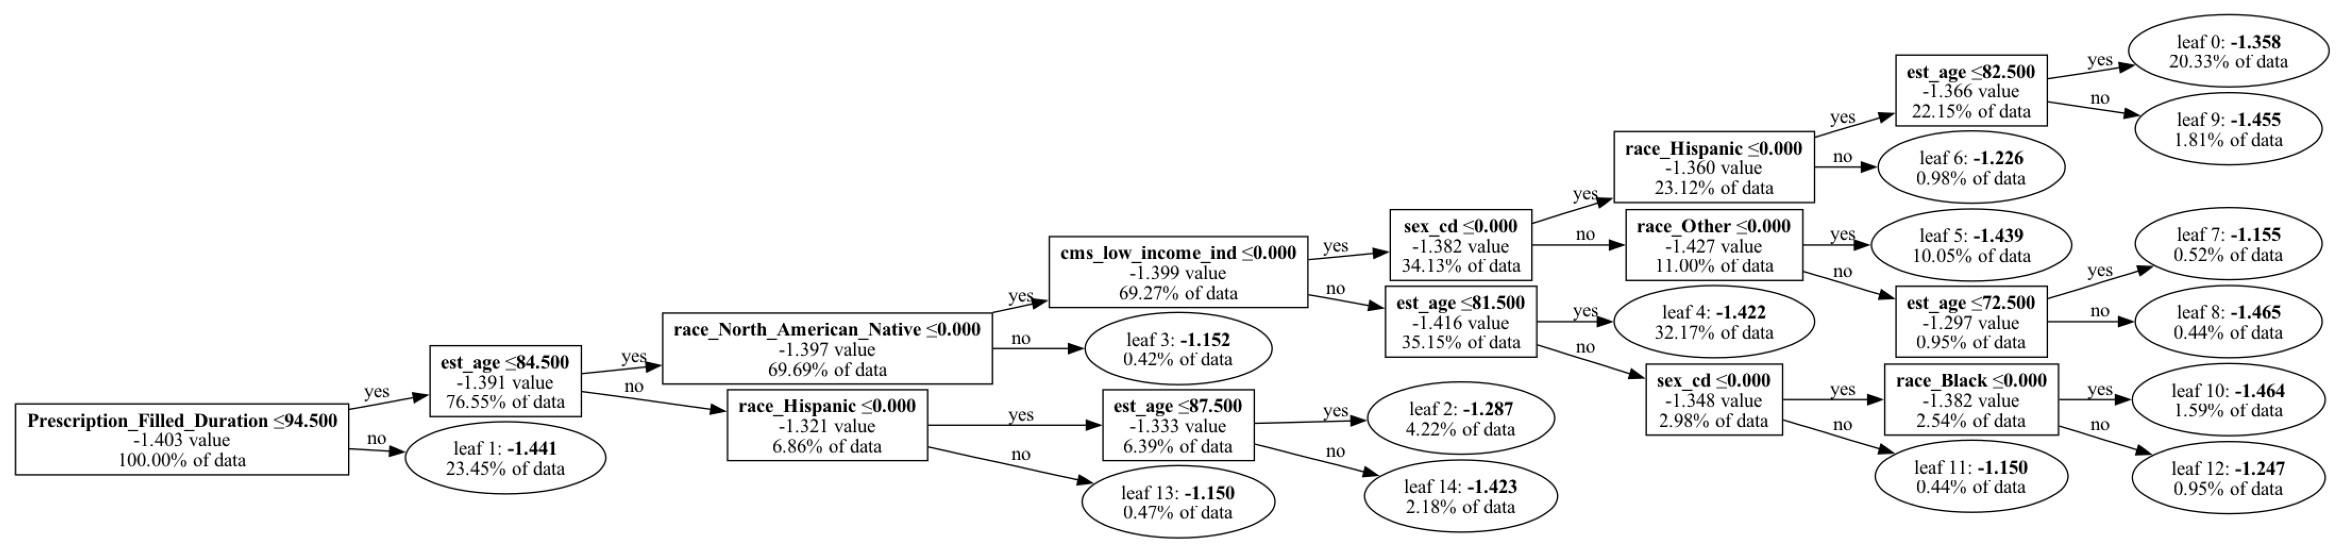

In [117]:
best_estimator = rand.best_estimator_
lgb.plot_tree(best_estimator, tree_index=0, show_info=['data_percentage', 'internal_value'], figsize=(30, 10))

Feature Importance

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

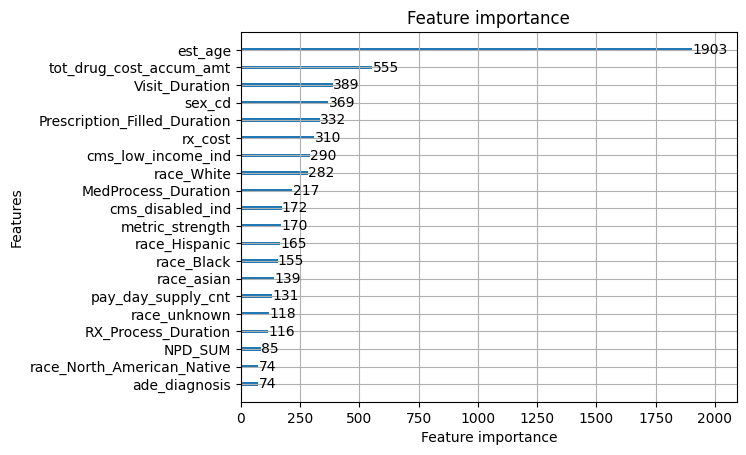

In [118]:
lgb.plot_importance(best_estimator,max_num_features=20 )

Export top features for further analysis

In [ ]:
topfeatures = test_scored[['est_age', 'tot_drug_cost_accum_amt','Visit_Duration','sex_cd','Prescription_Filled_Duration',
                           'rx_cost','cms_low_income_ind','race_White','MedProcess_Duration','cms_disabled_ind',
                           'metric_strength','race_Hispanic','race_Black','race_Asian','pay_day_supply_cnt',
                           'race_unknown','RX_Process_Duration','NPD_SUM','race_North American Native','ade_diagnosis']]

topfeatures.to_csv('/Users/nathanzlomke/Downloads/top20features.csv')